In [87]:
import pandas as pd
import numpy as np
from influxdb_client import InfluxDBClient
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import warnings
from influxdb_client.client.warnings import MissingPivotFunction

In [88]:
# Suppress the MissingPivotFunction warnings
warnings.simplefilter("ignore", MissingPivotFunction)

# InfluxDB connection parameters
load_dotenv(dotenv_path=".env")

INFLUX_URL = "http://localhost:8086"
INFLUX_TOKEN = os.getenv("INFLUX_TOKEN")
INFLUX_ORG = os.getenv("INFLUX_ORG", "none")
INFLUX_BUCKET = os.getenv("INFLUX_BUCKET", "bucket")

# Initialize the InfluxDB client
client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

In [89]:
start_time = "2025-03-23T10:30:00Z"
end_time = "2025-03-30T10:25:00Z"

In [90]:

query = f'''
from(bucket: "{INFLUX_BUCKET}")
    |> range(start: {start_time}, stop: {end_time})
    |> filter(fn: (r) => r._measurement == "temperature")
    |> filter(fn: (r) => r._field == "celsius")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

result = query_api.query_data_frame(query)
temp_df = pd.concat(result, ignore_index=True)
temp_df = temp_df[['_time', 'celsius', 'room']]

In [91]:
temp_df

,_time,celsius,room
0,2025-03-28 09:51:20.911583+00:00,22.561933,NaN
1,2025-03-28 09:56:20.911583+00:00,22.838495,NaN
2,2025-03-28 10:01:20.911583+00:00,22.751012,NaN
3,2025-03-28 10:06:20.911583+00:00,22.691527,NaN
4,2025-03-28 10:11:20.911583+00:00,22.375233,NaN
...,...,...,...
29781,2025-03-30 10:22:45.132591+00:00,22.980000,dorm6
29782,2025-03-30 10:23:15.783682+00:00,22.450000,dorm6
29783,2025-03-30 10:23:52.314964+00:00,22.860000,dorm6
29784,2025-03-30 10:24:12.397587+00:00,23.110000,dorm6


In [92]:
temp_df = temp_df[temp_df['room'].notna()]

In [93]:
temp_df['room'].unique()

array(['dorm1', 'dorm2', 'dorm3', 'dorm4', 'dorm5', 'dorm6'], dtype=object)

In [94]:
# 1. Handle the '_time' column:
#    - Convert it to datetime objects.
#    - Extract relevant features (hour, minute, etc.).
#    - Drop the original '_time' column.
temp_df['_time'] = pd.to_datetime(temp_df['_time'])
temp_df['hour'] = temp_df['_time'].dt.hour
temp_df['minute'] = temp_df['_time'].dt.minute
temp_df['dayofweek'] = temp_df['_time'].dt.dayofweek  # Monday=0, Sunday=6

# 2. Handle the 'room' column:
#    - Use one-hot encoding (create dummy variables).
#    - Drop one of the dummy columns to avoid multicollinearity.
temp_df = pd.get_dummies(temp_df, columns=['room'], drop_first=False)

# 3. Prepare the data for the model:
#    - Separate features (X) and target (y).
X = temp_df.drop(['celsius', '_time'], axis=1)  # Features: all columns except 'celsius' and '_time'
y = temp_df['celsius']             # Target: 'celsius' column

# 4. Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

# 5. Create and train a Linear Regression model:
model = LinearRegression()
model.fit(X_train, y_train)

/var/folders/fs/mzyq2p7d5dj3ptjl6rhvxd240000gn/T/ipykernel_11837/3933720207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['_time'] = pd.to_datetime(temp_df['_time'])
/var/folders/fs/mzyq2p7d5dj3ptjl6rhvxd240000gn/T/ipykernel_11837/3933720207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['hour'] = temp_df['_time'].dt.hour
/var/folders/fs/mzyq2p7d5dj3ptjl6rhvxd240000gn/T/ipykernel_11837/3933720207.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

LinearRegression()

In [95]:
temp_df

,_time,celsius,hour,minute,dayofweek,room_dorm1,room_dorm2,room_dorm3,room_dorm4,room_dorm5,room_dorm6
2312,2025-03-23 10:30:39.322934+00:00,26.71,10,30,6,True,False,False,False,False,False
2313,2025-03-23 10:35:39.322934+00:00,26.97,10,35,6,True,False,False,False,False,False
2314,2025-03-23 10:40:39.322934+00:00,27.20,10,40,6,True,False,False,False,False,False
2315,2025-03-23 10:45:39.322934+00:00,27.09,10,45,6,True,False,False,False,False,False
2316,2025-03-23 10:50:39.322934+00:00,26.59,10,50,6,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
29781,2025-03-30 10:22:45.132591+00:00,22.98,10,22,6,False,False,False,False,False,True
29782,2025-03-30 10:23:15.783682+00:00,22.45,10,23,6,False,False,False,False,False,True
29783,2025-03-30 10:23:52.314964+00:00,22.86,10,23,6,False,False,False,False,False,True
29784,2025-03-30 10:24:12.397587+00:00,23.11,10,24,6,False,False,False,False,False,True


Mean Squared Error: 4.690422336386855


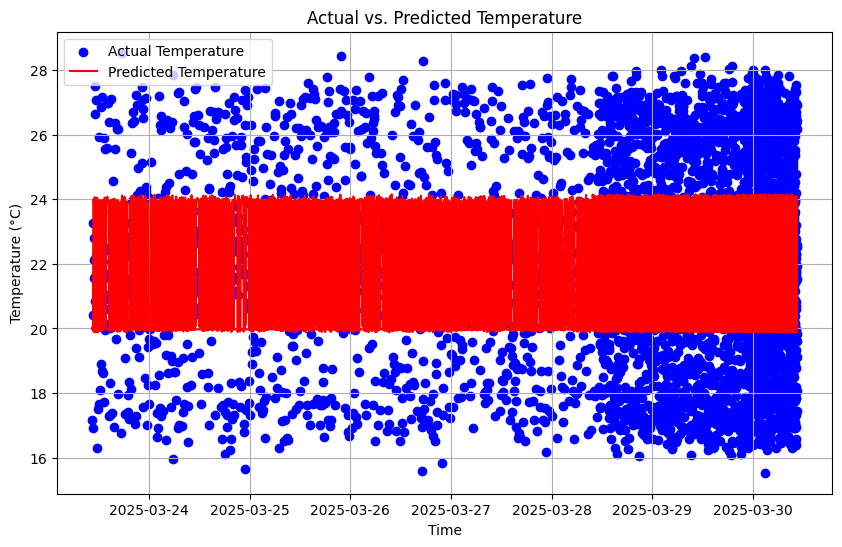

In [96]:
# 6. Make predictions on the test set:
y_pred = model.predict(X_test)

# 7. Evaluate the model's performance:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 8. (Optional) Make a prediction for a new data point:
# new_data = pd.DataFrame({
#     'hour': [14],
#     'minute': [30],
#     'dayofweek': [1],
#     'room_dorm2': [0],  # Example:  Assuming 'dorm2' is one of the rooms
#     'room_dorm3': [1],
#     'room_dorm4': [0],
#     'room_dorm5': [0],
#     'room_dorm6': [0]
# })
# predicted_temperature = model.predict(new_data)
# print(f'Predicted temperature: {predicted_temperature[0]:.2f} °C')

# 9. Plotting the results:
plt.figure(figsize=(10, 6))

# Create a time index for the test set
time_test = temp_df['_time'].iloc[-len(y_test):]

plt.scatter(time_test, y_test, color='blue', label='Actual Temperature')  # Actual test data
plt.plot(time_test, y_pred, color='red', label='Predicted Temperature')  # Predictions
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()

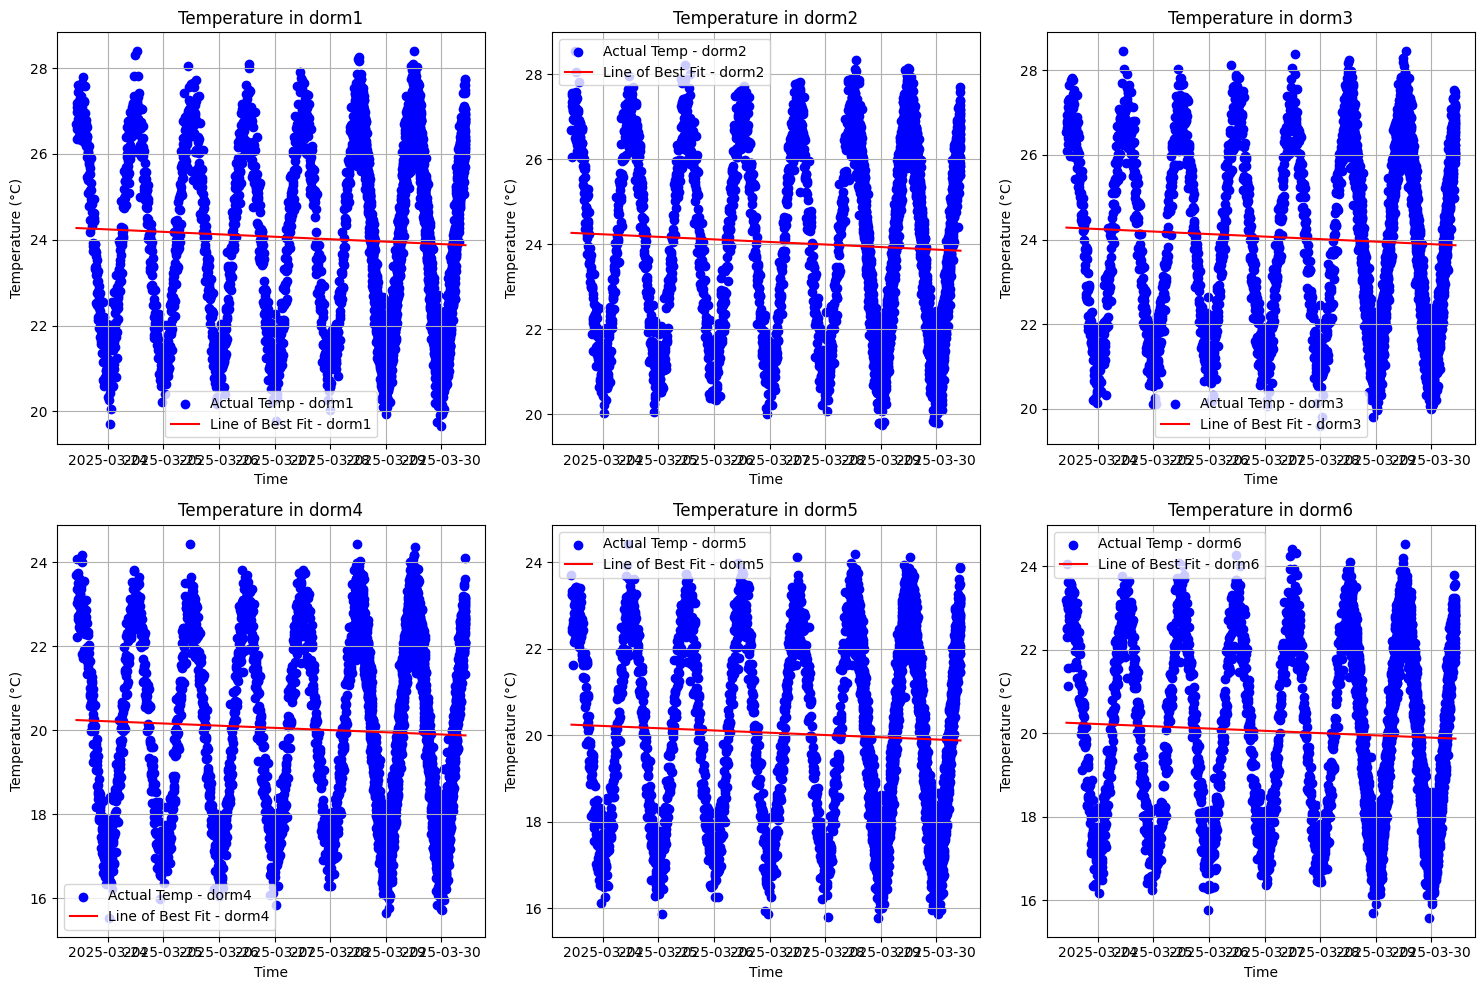

In [98]:
# 9. Plotting the results for each room:
plt.figure(figsize=(15, 10))  # Adjust figure size for multiple subplots
rooms = ['dorm1', 'dorm2', 'dorm3', 'dorm4', 'dorm5', 'dorm6']  # Assuming these are the room names

for i, room in enumerate(rooms):
    plt.subplot(2, 3, i + 1)  # Create subplots in a 2x3 grid
    room_df = temp_df[temp_df[f'room_{room}'] == 1]  # Filter data for the current room
    time_room = room_df['_time']
    temp_room = room_df['celsius']

    # Fit a linear regression model for this room
    model_room = LinearRegression()
    model_room.fit(pd.DataFrame(time_room.astype('int64')), temp_room)  # Fit on time as integer
    y_pred_room = model_room.predict(pd.DataFrame(time_room.astype('int64')))  # Predict

    plt.scatter(time_room, temp_room, color='blue', label=f'Actual Temp - {room}')
    plt.plot(time_room, y_pred_room, color='red', label=f'Line of Best Fit - {room}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature in {room}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
